In [40]:
import argparse
import os
import gzip

from termcolor import cprint

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.cm as cm
from matplotlib import pyplot as plt


from vis.visualization import visualize_saliency, overlay, visualize_cam
from vis.utils import utils

import tensorflow as tf

import cv2
from keras import models 
from keras import backend as K

In [41]:
def binary_focal_loss(y_true, y_pred):
  """
  :param y_true: A tensor of the same shape as `y_pred`
  :param y_pred:  A tensor resulting from a sigmoid
  :return: Output tensor.
  """
  gamma = 2.
  alpha = .25

  pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
  pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

  epsilon = K.epsilon()
  # clip to prevent NaN's and Inf's
  pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
  pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

  return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
         - K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

In [43]:
def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [48]:
def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  

    return cam

In [44]:
def GradCamPlusPlus(model, img_array, layer_name):
    cls = model.predict(img_array)
    y_c = model.output[0]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)
    
    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
  
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom
    
    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0

    return cam

In [80]:
img1 = Image.open("2018-03-29_02-33-16.png")
arr1 = np.array(img1)
arr1 = arr1[0:300,]
arr1_old = arr1
arr1 = arr1 / 255
arr1 = arr1.reshape((1,)+arr1.shape+(1,))

In [85]:
img2 = Image.open("34_29465_1524965783_1524965794.png")
arr2 = np.array(img2)
arr2 = arr2[0:300,]
arr2_old = arr2
arr2 = arr2 / 255
arr2 = arr2.reshape((1,)+arr2.shape+(1,))

In [61]:
model = models.load_model("model6.hdf5", custom_objects = {"loss_function": binary_focal_loss})
output = model.predict(arr1)
print("Keras output:")
print(output)

#2018-03-29_02-33-16.png is negative

Keras output:
[[0.08279597]]


In [58]:
output = model.predict(arr2)
print("Keras output:")
print(output)

#34_29465_1524965783_1524965794.png is positive

Keras output:
[[0.99961275]]


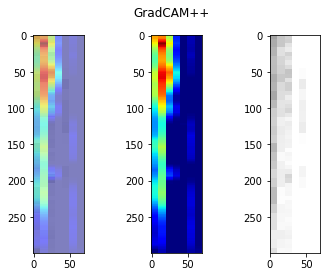

In [66]:
grads = GradCamPlusPlus(model, arr1, "conv4")
grads = cv2.resize(grads, (7, 300))
grads = np.repeat(grads, 10, axis = 1)
arr1_old = cv2.bitwise_not(np.repeat(arr1_old, 10, axis = 1))
arr1_old = arr1_old.reshape(arr1_old.shape+(1,))
arr1_old = cv2.cvtColor(arr1_old, cv2.COLOR_GRAY2BGR)
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

f, ax = plt.subplots(1, 3)
plt.suptitle("GradCAM++")
ax[0].imshow(overlay(jet_heatmap, arr1_old))
ax[1].imshow(jet_heatmap)
ax[2].imshow(arr1_old)
plt.show()


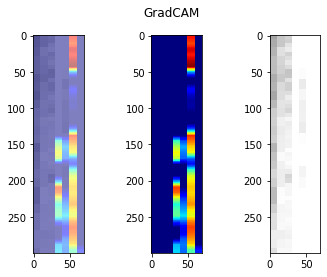

In [76]:
grads = GradCam(model, arr1, "conv4")
grads = cv2.resize(grads, (7, 300))
grads = np.repeat(grads, 10, axis = 1)
arr1_old = cv2.bitwise_not(np.repeat(arr1_old, 10, axis = 1))
arr1_old = arr1_old.reshape(arr1_old.shape+(1,))
arr1_old = cv2.cvtColor(arr1_old, cv2.COLOR_GRAY2BGR)
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

f, ax = plt.subplots(1, 3)
plt.suptitle("GradCAM")
ax[0].imshow(overlay(jet_heatmap, arr1_old))
ax[1].imshow(jet_heatmap)
ax[2].imshow(arr1_old)
plt.show()

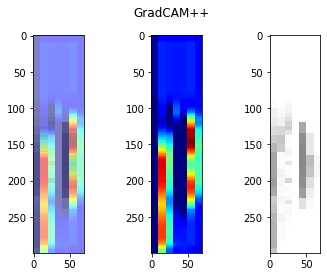

In [86]:
grads = GradCamPlusPlus(model, arr2, "conv4")
grads = cv2.resize(grads, (7, 300))
grads = np.repeat(grads, 10, axis = 1)
arr2_old = cv2.bitwise_not(np.repeat(arr2_old, 10, axis = 1))
arr2_old = arr2_old.reshape(arr2_old.shape+(1,))
arr2_old = cv2.cvtColor(arr2_old, cv2.COLOR_GRAY2BGR)
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

f, ax = plt.subplots(1, 3)
plt.suptitle("GradCAM++")
ax[0].imshow(overlay(jet_heatmap, arr2_old))
ax[1].imshow(jet_heatmap)
ax[2].imshow(arr2_old)
plt.show()



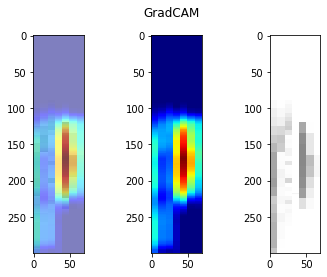

In [82]:
grads = GradCam(model, arr2, "conv4")
grads = cv2.resize(grads, (7, 300))
grads = np.repeat(grads, 10, axis = 1)
arr2_old = cv2.bitwise_not(np.repeat(arr2_old, 10, axis = 1))
arr2_old = arr2_old.reshape(arr2_old.shape+(1,))
arr2_old = cv2.cvtColor(arr2_old, cv2.COLOR_GRAY2BGR)
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

f, ax = plt.subplots(1, 3)
plt.suptitle("GradCAM")
ax[0].imshow(overlay(jet_heatmap, arr2_old))
ax[1].imshow(jet_heatmap)
ax[2].imshow(arr2_old)
plt.show()

